### Dataset Description

<div>

  <h3>topics.csv</h3>
  <p>
    topics.csv - Contains a row for each topic in the dataset. These topics are organized into "channels", with each channel containing a single "topic tree" (which can be traversed through the "parent" reference). Note that the hidden dataset used for scoring contains additional topics not in the public version. You should only submit predictions for those topics listed in sample_submission.csv.
  </p>
  <ul>
    <li><strong>id</strong> - A unique identifier for this topic.</li>
    <li><strong>title</strong> - Title text for this topic.</li>
    <li><strong>description</strong> - Description text (may be empty)</li>
    <li><strong>channel</strong> - The channel (that is, topic tree) this topic is part of.</li>
    <li><strong>category</strong> - Describes the origin of the topic.</li>
    <ul>
    <li><strong>source</strong> - Structure was given by original content creator (e.g. the topic tree as imported from Khan Academy). There are no topics in the test set with this category.</li>
    <li><strong>aligned</strong> - Structure is from a national curriculum or other target taxonomy, with content aligned from multiple sources.</li>
    <li><strong>supplemental</strong> - This is a channel that has to some extent been aligned, but without the same level of granularity or fidelity as an aligned channel.</li>
    </ul>
    <li><strong>language</strong> - Language code for the topic. May not always match apparent language of its title or description, but will always match the language of any associated content items.</li>
    <li><strong>parent</strong> - The id of the topic that contains this topic, if any. This field if empty if the topic is the root node for its channel.</li>
    <li><strong>level</strong> - The depth of this topic within its topic tree. Level 0 means it is a root node (and hence its title is the title of the channel).</li>
    <li><strong>has_content</strong> - Whether there are content items correlated with this topic. Most content is correlated with leaf topics, but some non-leaf topics also have content correlations.</li>
  </ul>

  <h3>content.csv</h3>
  <p>
    content.csv - Contains a row for each content item in the dataset. Note that the hidden dataset used for scoring contains additional content items not in the public version. These additional content items are only correlated to topics in the test set. Some content items may not be correlated with any topic.
  </p>
  <ul>
    <li><strong>id</strong> - A unique identifier for this content item.</li>
    <li><strong>title</strong> - Title text for this content item.</li>
    <li><strong>description</strong> - Description text. May be empty.</li>
    <li><strong>language</strong> - Language code representing the language of this content item.</li>
    <li><strong>kind</strong> - Describes what format of content this item represents, as one of:<br></li>
      <ul>
      <li><strong>document</strong> (text is extracted from a PDF or EPUB file)<br></li>
      <li><strong>video</strong> (text is extracted from the subtitle file, if available)<br></li>
      <li><strong>exercise</strong> (text is extracted from questions/answers)<br></li>
      <li><strong>audio</strong> (no text)<br></li>
      <li><strong>html5</strong> (text is extracted from HTML source)</li>
    </ul>
    <li><strong>text</strong> - Extracted text content, if available and if licensing permitted (around half of content items have text content).</li>
    <li><strong>copyright_holder</strong> - If text was extracted from the content, indicates the owner of the copyright for that content. Blank for all test set items.</li>
    <li><strong>license</strong> - If text was extracted from the content, the license under which that content was made available. Blank for all test set items.</li>
  </ul>

  <h3>correlations.csv</h3>
  <p>
    correlations.csv The content items associated to topics in the training set. A single content item may be associated to more than one topic. In each row, we give a topic_id and a list of all associated content_ids. These comprise the targets of the training set.
  </p>

</div>


### Goal

Build a “classifier” that is capable of matching content to topics. The inputs to the model
should only be based on what is provided in the dataset (i.e. do not pull third party data sources)
and the model should output a list of topic ids that match a given piece of content.

## Code

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Content to Topics Dataset

Here, we convert corelations.csv dataset to correlations_content_to_topics.csv

Schema:
topic_id(str), content_ids(list[str]) ---> content_id(str), topic_ids(list[str])

In [2]:
df_corr = pd.read_csv('../data/learning-equality-curriculum-recommendations/correlations.csv')
df_corr.head()

,topic_id,content_ids
0,t_00004da3a1b2,c_1108dd0c7a5d c_376c5a8eb028 c_5bc0e1e2cba0 c...
1,t_00068291e9a4,c_639ea2ef9c95 c_89ce9367be10 c_ac1672cdcd2c c...
2,t_00069b63a70a,c_11a1dc0bfb99
3,t_0006d41a73a8,c_0c6473c3480d c_1c57a1316568 c_5e375cf14c47 c...
4,t_0008768bdee6,c_34e1424229b4 c_7d1a964d66d5 c_aab93ee667f4


In [3]:
df_corr.shape

(61517, 2)

In [4]:
corr_exploded=(
    df_corr
    .assign(content_id=df_corr["content_ids"].str.split(" "))
    .explode("content_id")
    [["topic_id", "content_id"]]
)

corr_exploded.head()

,topic_id,content_id
0,t_00004da3a1b2,c_1108dd0c7a5d
0,t_00004da3a1b2,c_376c5a8eb028
0,t_00004da3a1b2,c_5bc0e1e2cba0
0,t_00004da3a1b2,c_76231f9d0b5e
1,t_00068291e9a4,c_639ea2ef9c95


In [5]:
content_to_topics = (
    corr_exploded
    .groupby("content_id")["topic_id"]
    .apply(list)
    .reset_index()
)

content_to_topics.head()

,content_id,topic_id
0,c_00002381196d,"[t_81be1094dd83, t_d0edb1c53d90, t_d66311c2e17..."
1,c_000087304a9e,"[t_696e745e6d1f, t_c5a64afaec08]"
2,c_0000ad142ddb,[t_66f09929d0d3]
3,c_0000c03adc8d,[t_472e0a2df5f7]
4,c_00016694ea2a,"[t_7a81e3d4aeae, t_bc8f347a0b19]"


In [6]:
content_to_topics["topic_ids"] = content_to_topics["topic_id"].apply(lambda ids: " ".join(sorted(set(ids))))

content_to_topics = content_to_topics[["content_id", "topic_ids"]]

content_to_topics.head()

,content_id,topic_ids
0,c_00002381196d,t_81be1094dd83 t_d0edb1c53d90 t_d66311c2e171 t...
1,c_000087304a9e,t_696e745e6d1f t_c5a64afaec08
2,c_0000ad142ddb,t_66f09929d0d3
3,c_0000c03adc8d,t_472e0a2df5f7
4,c_00016694ea2a,t_7a81e3d4aeae t_bc8f347a0b19


In [8]:
content_to_topics.shape

(154047, 2)

#### Saving content to topics file

With this file we can calculate the metrics for the proposed challenge.

In [ ]:
#content_to_topics.to_csv("../data/correlations_content_to_topics.csv", index=False)


### Analysis

#### Content

In [9]:
df_content = pd.read_csv('../data/learning-equality-curriculum-recommendations/content.csv')
df_content.head()

,id,title,description,kind,text,language,copyright_holder,license
0,c_00002381196d,"Sumar números de varios dígitos: 48,029+233,930","Suma 48,029+233,930 mediante el algoritmo está...",video,NaN,es,NaN,NaN
1,c_000087304a9e,Trovare i fattori di un numero,Sal trova i fattori di 120.\n\n,video,NaN,it,NaN,NaN
2,c_0000ad142ddb,Sumar curvas de demanda,Cómo añadir curvas de demanda\n\n,video,NaN,es,NaN,NaN
3,c_0000c03adc8d,Nado de aproximação,Neste vídeo você vai aprender o nado de aproxi...,document,\nNado de aproximação\nSaber nadar nas ondas ...,pt,Sikana Education,CC BY-NC-ND
4,c_00016694ea2a,geometry-m3-topic-a-overview.pdf,geometry-m3-topic-a-overview.pdf,document,Estándares Comunes del Estado de Nueva York\n\...,es,Engage NY,CC BY-NC-SA


In [10]:
len_content_dataset, len_feat_content = df_content.shape
len_content_dataset, len_feat_content

(154047, 8)

In [11]:
df_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154047 entries, 0 to 154046
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                154047 non-null  object
 1   title             154038 non-null  object
 2   description       89456 non-null   object
 3   kind              154047 non-null  object
 4   text              74035 non-null   object
 5   language          154047 non-null  object
 6   copyright_holder  71821 non-null   object
 7   license           74035 non-null   object
dtypes: object(8)
memory usage: 9.4+ MB


In [12]:
id_not_null = df_content.id.notna().sum()
id_duplicated = df_content.id.duplicated().sum()
print(f"Not null id: {id_not_null}\nDuplicated ids: {id_duplicated}")

Not null id: 154047
Duplicated ids: 0


In [13]:
def percent_content_dataset(value, len_dataset):
    return round(value/len_dataset, 5) * 100

In [14]:
title_not_null = df_content.title.notna().sum()
desc_not_null = df_content.description.notna().sum()
text_not_null = df_content.text.notna().sum()
print(f"Not null features:\
      \nTitles:{percent_content_dataset(title_not_null, len_content_dataset)}% \
      \nDescription:{percent_content_dataset(desc_not_null, len_content_dataset)}%\
      \nText:{percent_content_dataset(text_not_null, len_content_dataset)}%")

Not null features:      
Titles:99.994%       
Description:58.071%      
Text:48.06%


When analyzing the content.csv file, we observe an uneven distribution across the three textual fields that contain the most relevant information for each content item: title, description, and extracted text. Nearly all entries include a title (99.994%), ensuring that every item has at least a minimal form of identification. Descriptions are available for approximately 58.07% of the records, providing additional context but still missing in almost half of the dataset. Finally, only 48.06% of the items contain full extracted text, meaning that more than half of the content relies solely on title and/or description for semantic representation.

In [15]:
df_content[df_content.title.notna() == False]

,id,title,description,kind,text,language,copyright_holder,license
13006,c_159f205b73db,NaN,Recurso Educativo Abierto para Geografía e His...,document,"La guerra una y otra vez\nLa guerra, una y otr...",es,Centro Nacional de Desarrollo Curricular en Si...,CC BY-SA
19282,c_200ae87baf4d,NaN,Recurso Educativo Abierto para Geografía e His...,document,La economía y yo\nLa economía y yo\nObra publi...,es,Centro Nacional de Desarrollo Curricular en Si...,CC BY-SA
36142,c_3c070b63a944,NaN,NaN,document,"Palabra de caballero\nPalabra de caballero\n""P...",es,Centro Nacional de Desarrollo Curricular en Si...,CC BY-SA
71510,c_77105b4b84cc,NaN,NaN,document,Un espíritu revestido de piel humana\nUn espír...,es,Centro Nacional de Desarrollo Curricular en Si...,CC BY-SA
71677,c_77574ef20c1f,NaN,Recurso Educativo Abierto para Ciencias Natura...,document,"¿Es magia? No, son reacciones químicas\n¿Es ma...",es,Centro Nacional de Desarrollo Curricular en Si...,CC BY-SA
81818,c_87e171afe50b,NaN,NaN,document,La curiosidad es saludable\nLa curiosidad es s...,es,Centro Nacional de Desarrollo Curricular en Si...,CC BY-SA
96490,c_a04562126266,NaN,NaN,document,Para provecho y deleite\nPara provecho y delei...,es,Centro Nacional de Desarrollo Curricular en Si...,CC BY-SA
132178,c_db7818729577,NaN,NaN,document,Historia inicial\nHistoria inicial\n-\tY pasan...,es,Centro Nacional de Desarrollo Curricular en Si...,CC BY-SA
144353,c_efb73ad83f4b,NaN,NaN,document,Orientaciones para el profesorado\nOrientacion...,es,Centro Nacional de Desarrollo Curricular en Si...,CC BY-SA


All items without a title still contain text, which provides enough information to identify and characterize the content.

#### Topics

In [17]:
df_topics = pd.read_csv('../data/learning-equality-curriculum-recommendations/topics.csv')
df_topics.head()

,id,title,description,channel,category,level,language,parent,has_content
0,t_00004da3a1b2,Откриването на резисторите,"Изследване на материали, които предизвикват на...",000cf7,source,4,bg,t_16e29365b50d,True
1,t_000095e03056,Unit 3.3 Enlargements and Similarities,NaN,b3f329,aligned,2,en,t_aa32fb6252dc,False
2,t_00068291e9a4,Entradas e saídas de uma função,Entenda um pouco mais sobre funções.,8e286a,source,4,pt,t_d14b6c2a2b70,True
3,t_00069b63a70a,Transcripts,NaN,6e3ba4,source,3,en,t_4054df11a74e,True
4,t_0006d41a73a8,Графики на експоненциални функции (Алгебра 2 н...,Научи повече за графиките на сложните показате...,000cf7,source,4,bg,t_e2452e21d252,True


In [18]:
len_topics_df, len_feat_topics = df_topics.shape
len_topics_df, len_feat_topics

(76972, 9)

In [19]:
df_topics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76972 entries, 0 to 76971
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           76972 non-null  object
 1   title        76970 non-null  object
 2   description  34953 non-null  object
 3   channel      76972 non-null  object
 4   category     76972 non-null  object
 5   level        76972 non-null  int64 
 6   language     76972 non-null  object
 7   parent       76801 non-null  object
 8   has_content  76972 non-null  bool  
dtypes: bool(1), int64(1), object(7)
memory usage: 4.8+ MB


In [20]:
title_not_null = df_topics.title.notna().sum()
desc_not_null = df_topics.description.notna().sum()
parent_not_null = df_topics.parent.notna().sum()
print(f"Not null features:\
      \nTitles:{percent_content_dataset(title_not_null, len_topics_df)}%\
      \nDescription:{percent_content_dataset(desc_not_null, len_topics_df)}%\
      \nParent:{percent_content_dataset(parent_not_null, len_topics_df)}%")

Not null features:      
Titles:99.997%      
Description:45.410000000000004%      
Parent:99.778%


In the topics.csv file, the three key fields used to represent each topic—title, description, and parent—also show significant variation in completeness. Almost all topics include a title (99.997%), ensuring that each node in the taxonomy has at least a basic, human-readable label. However, only 45.41% of topics provide a description, limiting the amount of semantic detail available for many entries. In contrast, the parent field is present for 99.778% of the records, reflecting the strong hierarchical structure of the curriculum and enabling the reconstruction of topic trees even when descriptive text is sparse. This imbalance highlights that most topics can be located clearly within the hierarchy, but their semantic richness varies considerably depending on the availability of descriptive information.

In [21]:
df_topics.channel.unique().shape

(171,)

In [22]:
df_topics.language.unique().shape

(28,)

In [23]:
df_topics.has_content.value_counts()

has_content
True     61517
False    15455
Name: count, dtype: int64

In [24]:
df_topics.level.value_counts().sort_index()

level
0       171
1      1104
2      4874
3     14898
4     38810
5      9744
6      6210
7      1028
8       119
9        12
10        2
Name: count, dtype: int64

In [25]:
temp = []

for desc in df_topics.description:
    if desc is np.nan:
        temp.append(0)
    else:
        temp.append(len(desc))

In [33]:
df_test = pd.DataFrame({"Values":temp})
df_test

,Values
0,130
1,0
2,36
3,0
4,80
...,...
76967,0
76968,132
76969,0
76970,24


In [34]:
q_25=df_test["Values"].quantile(0.25)
q_75=df_test["Values"].quantile(0.75)
q_99=df_test["Values"].quantile(0.99)
q_9999=df_test["Values"].quantile(0.9999)


print(f"Q_25%->{q_25}\nQ_75%->{q_75}\nQ_99%->{q_99}\nQ_99.99%->{q_9999}")

Q_25%->0.0
Q_75%->106.0
Q_99%->746.2899999999936
Q_99.99%->3559.1717999973625


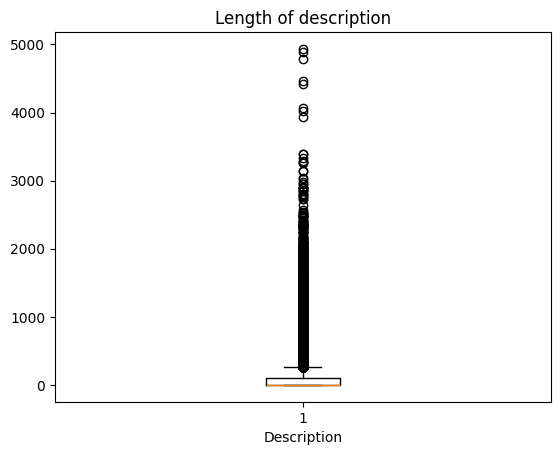

In [35]:
plt.boxplot(df_test)
plt.title("Length of description")
plt.xlabel("Description")
plt.show()

The distribution of topic description lengths is highly skewed, with most descriptions being extremely short or entirely absent. The 25th percentile is 0, indicating that at least a quarter of topics provide no descriptive text at all. Even at the 75th percentile (106 characters), descriptions remain brief, offering only limited semantic information. Only in the extreme upper tail do longer descriptions appear: the 99th percentile reaches ~746 characters, and the 99.99th percentile exceeds 3,500 characters, showing that a very small number of topics contain unusually detailed and verbose descriptions. This long-tailed pattern highlights the scarcity of rich textual information across the majority of topics, underscoring the importance of leveraging hierarchical structure (e.g., parent relationships) to enrich topic embeddings when using similarity-based models.

### Transforming infomation into embeddings

For each topic item, we will construct its embedding based on title, description and parent's title.

In [36]:
df_topics = df_topics.merge(
    df_topics[["id", "title"]].rename(columns={"id": "parent", "title": "parent_title"}),
    on="parent",
    how="left"
)
df_topics.head()

,id,title,description,channel,category,level,language,parent,has_content,parent_title
0,t_00004da3a1b2,Откриването на резисторите,"Изследване на материали, които предизвикват на...",000cf7,source,4,bg,t_16e29365b50d,True,Открития и проекти
1,t_000095e03056,Unit 3.3 Enlargements and Similarities,NaN,b3f329,aligned,2,en,t_aa32fb6252dc,False,Junior High Level 3
2,t_00068291e9a4,Entradas e saídas de uma função,Entenda um pouco mais sobre funções.,8e286a,source,4,pt,t_d14b6c2a2b70,True,Álgebra: funções
3,t_00069b63a70a,Transcripts,NaN,6e3ba4,source,3,en,t_4054df11a74e,True,Flow Charts: Logical Thinking?
4,t_0006d41a73a8,Графики на експоненциални функции (Алгебра 2 н...,Научи повече за графиките на сложните показате...,000cf7,source,4,bg,t_e2452e21d252,True,Показателни и логаритмични функции


In [ ]:
df_topics["full_info"] = ("title: " + df_topics["title"].fillna("") +
                          " description: " + df_topics["description"].fillna("") +
                          " parent_title: " + df_topics["parent_title"].fillna("")
                          )

df_topics.head()

,id,title,description,channel,category,level,language,parent,has_content,parent_title,full_info
0,t_00004da3a1b2,Откриването на резисторите,"Изследване на материали, които предизвикват на...",000cf7,source,4,bg,t_16e29365b50d,True,Открития и проекти,title: Откриването на резисторите description:...
1,t_000095e03056,Unit 3.3 Enlargements and Similarities,NaN,b3f329,aligned,2,en,t_aa32fb6252dc,False,Junior High Level 3,title: Unit 3.3 Enlargements and Similarities ...
2,t_00068291e9a4,Entradas e saídas de uma função,Entenda um pouco mais sobre funções.,8e286a,source,4,pt,t_d14b6c2a2b70,True,Álgebra: funções,title: Entradas e saídas de uma função descrip...
3,t_00069b63a70a,Transcripts,NaN,6e3ba4,source,3,en,t_4054df11a74e,True,Flow Charts: Logical Thinking?,title: Transcripts description:
4,t_0006d41a73a8,Графики на експоненциални функции (Алгебра 2 н...,Научи повече за графиките на сложните показате...,000cf7,source,4,bg,t_e2452e21d252,True,Показателни и логаритмични функции,title: Графики на експоненциални функции (Алге...


For each content item, we will construct its embedding based on title, description and text.

In [ ]:
df_content["full_info"] = "title: " + df_content["title"].fillna("") + \
            " description: " + df_content["description"].fillna("") + \
            " text" + df_content["text"].fillna("")

df_content.head()

,id,title,description,kind,text,language,copyright_holder,license,full_info
0,c_00002381196d,"Sumar números de varios dígitos: 48,029+233,930","Suma 48,029+233,930 mediante el algoritmo está...",video,NaN,es,NaN,NaN,"title: Sumar números de varios dígitos: 48,029..."
1,c_000087304a9e,Trovare i fattori di un numero,Sal trova i fattori di 120.\n\n,video,NaN,it,NaN,NaN,title: Trovare i fattori di un numero descript...
2,c_0000ad142ddb,Sumar curvas de demanda,Cómo añadir curvas de demanda\n\n,video,NaN,es,NaN,NaN,title: Sumar curvas de demanda description: Có...
3,c_0000c03adc8d,Nado de aproximação,Neste vídeo você vai aprender o nado de aproxi...,document,\nNado de aproximação\nSaber nadar nas ondas ...,pt,Sikana Education,CC BY-NC-ND,title: Nado de aproximação description: Neste ...
4,c_00016694ea2a,geometry-m3-topic-a-overview.pdf,geometry-m3-topic-a-overview.pdf,document,Estándares Comunes del Estado de Nueva York\n\...,es,Engage NY,CC BY-NC-SA,title: geometry-m3-topic-a-overview.pdf descri...


#### Sentence Transformer

For this project, a Sentence Transformer was chosen because the task is fundamentally a semantic matching problem: given a content item and a set of topics, the model must capture meaning and relate them based on textual similarity. Sentence Transformers are specifically designed for this type of task, producing dense vector representations that encode semantic relationships between sentences, paragraphs, and short documents, making them ideal for retrieval-based and ranking-based approaches. Among the available models, all-MiniLM-L6-v2 was selected due to its strong balance between performance and efficiency: it generates high-quality embeddings while remaining lightweight (6 transformer layers) and fast to compute, which is crucial for scaling to tens of thousands of content–topic comparisons. Additionally, this model is trained to produce cosine-meaningful embeddings, making it well suited for FAISS-based similarity search and for working with relatively short fields such as titles and descriptions, which dominate this dataset.

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")
#model = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v2')

sentences = [
    "The weather is lovely today.",
    "It's so sunny outside!",
    "He drove to the stadium.",
]

embeddings = model.encode(sentences)
print(embeddings.shape)

similarities = model.similarity(embeddings, embeddings)
print(similarities)

/home/lair/anaconda3/envs/llm_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(3, 384)
tensor([[1.0000, 0.6660, 0.1046],
        [0.6660, 1.0000, 0.1411],
        [0.1046, 0.1411, 1.0000]])


In [34]:
def create_embedding(full_text):
    return model.encode(full_text)

In [ ]:
df_topics["embedding"] = df_topics["full_info"].apply(create_embedding)
#df_topics.to_csv("../data/new_topics_MiniLM.csv", index=False)

In [ ]:
df_content["embedding"] = df_content["full_info"].apply(create_embedding)
#df_content.to_csv("../data/new_content_MiniLM.csv", index=False)

In [55]:
df_topics.head()

,id,title,description,channel,category,level,language,parent,has_content,parent_title,full_info,embedding
0,t_00004da3a1b2,Откриването на резисторите,"Изследване на материали, които предизвикват на...",000cf7,source,4,bg,t_16e29365b50d,True,Открития и проекти,title: Откриването на резисторите description:...,"[-0.08681582, 0.06817203, -0.0367307, -0.02083..."
1,t_000095e03056,Unit 3.3 Enlargements and Similarities,NaN,b3f329,aligned,2,en,t_aa32fb6252dc,False,Junior High Level 3,title: Unit 3.3 Enlargements and Similarities ...,"[-0.04983556, -0.020590978, -0.042217873, -0.0..."
2,t_00068291e9a4,Entradas e saídas de uma função,Entenda um pouco mais sobre funções.,8e286a,source,4,pt,t_d14b6c2a2b70,True,Álgebra: funções,title: Entradas e saídas de uma função descrip...,"[0.042085104, 0.04775989, -0.062615864, -0.017..."
3,t_00069b63a70a,Transcripts,NaN,6e3ba4,source,3,en,t_4054df11a74e,True,Flow Charts: Logical Thinking?,title: Transcripts description:,"[-0.07078689, 0.07895644, -0.04061069, -0.0032..."
4,t_0006d41a73a8,Графики на експоненциални функции (Алгебра 2 н...,Научи повече за графиките на сложните показате...,000cf7,source,4,bg,t_e2452e21d252,True,Показателни и логаритмични функции,title: Графики на експоненциални функции (Алге...,"[-0.008648734, 0.061268367, -0.026756654, 0.02..."
